<a href="https://colab.research.google.com/github/jasonbrelsford/ai-colab/blob/main/hlaB_57_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install requests
import requests
import json

def check_connection(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            print("Connection successful!")
        else:
            print(f"Failed to connect, status code: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error occurred: {e}")

# Test connection
fhir_server_url = "https://eng.hapiserver.nmdp.org/fhir/Patient"
check_connection(fhir_server_url)


# Define FHIR server URL and toxicity data endpoint
fhir_server_url = "https://eng.hapiserver.nmdp.org/fhir/Patient"
pubchem_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound"

# Define a function to fetch patients from the FHIR server
def fetch_patients():
    response = requests.get(fhir_server_url)
    if response.status_code == 200:
        return response.json().get('entry', [])
    else:
        print("Failed to fetch patients:", response.status_code, response.text)
        return []

# Define a function to check for toxicity information in PubChem
def check_toxicity(hla_typing):
    # In this case, we are interested in HLA-B*57:01 and abacavir
    if "HLA-B*57:01" in hla_typing:
        # You can modify this section to query specific toxicity data
        abacavir_info = requests.get(f"{pubchem_url}/name/abacavir/property/TOXICITY")
        if abacavir_info.status_code == 200:
            return abacavir_info.json()  # Return toxicity information
        else:
            print("Failed to fetch toxicity data:", abacavir_info.status_code, abacavir_info.text)
    return None

# Main function to execute the lookup and correlation
def main():
    patients = fetch_patients()
    for patient in patients:
        # Assuming the HLA information is in the extensions
        extensions = patient.get('resource', {}).get('extension', [])
        hla_typing = ""
        for ext in extensions:
            if ext['url'] == "http://hl7.org/fhir/StructureDefinition/hla-typing":
                hla_typing = ext['valueString']

        # Check for toxicity if HLA typing is present
        if hla_typing:
            toxicity_info = check_toxicity(hla_typing)
            if toxicity_info:
                print(f"Patient ID: {patient['resource']['id']}, HLA Typing: {hla_typing}, Toxicity Info: {toxicity_info}")
            else:
                print(f"Patient ID: {patient['resource']['id']}, HLA Typing: {hla_typing}, No toxicity information found.")
        else:
            print(f"Patient ID: {patient['resource']['id']}, No HLA typing found.")

if __name__ == "__main__":
    main()


Error occurred: HTTPSConnectionPool(host='eng.hapiserver.nmdp.org', port=443): Max retries exceeded with url: /fhir/Patient (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c9e6a9a4790>: Failed to resolve 'eng.hapiserver.nmdp.org' ([Errno -2] Name or service not known)"))


ConnectionError: HTTPSConnectionPool(host='eng.hapiserver.nmdp.org', port=443): Max retries exceeded with url: /fhir/Patient (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c9e83320fd0>: Failed to resolve 'eng.hapiserver.nmdp.org' ([Errno -2] Name or service not known)"))

In [ ]:
import requests
import matplotlib.pyplot as plt

def search_patients_with_hla_b5701():
    """Search the FHIR server for all patients with HLA B*57:01 allele."""
    fhir_url = "https://hapi.fhir.org/baseR4/Patient?genotype=hla-b*57:01"

    try:
        response = requests.get(fhir_url)
        response.raise_for_status()  # Check for HTTP errors

        data = response.json()
        return data
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching patient data from FHIR server: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching patient data from FHIR server: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching patient data from FHIR server: {e}")

def search_pubchem_for_drug_toxicity(drug_name):
    """Fetch toxicity information of a drug from PubChem."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/property/TOXICITY/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        data = response.json()
        toxicity = data.get('PropertyTable', {}).get('Properties', [{}])[0].get('TOXICITY', 'No toxicity information available')
        return toxicity
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e}")

def correlate_hla_with_drug_toxicity(patient_data, drug_list):
    """Correlate patients with HLA B*57:01 with toxicity of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_status = "HLA B*57:01 detected" if "hla-b*57:01" in str(patient_info).lower() else "HLA B*57:01 not detected"

        for drug in drug_list:
            toxicity = search_pubchem_for_drug_toxicity(drug)
            results.append((patient_name, drug, hla_status, toxicity))

    return results

def plot_results(results):
    """Plot the correlation between HLA B*57:01 and drug toxicity."""
    hla_detected = [item for item in results if item[2] == "HLA B*57:01 detected"]
    drug_names = [item[1] for item in hla_detected]
    toxicities = [item[3] for item in hla_detected]

    plt.figure(figsize=(10, 6))
    plt.barh(drug_names, toxicities, color='orange')
    plt.xlabel('Toxicity Information')
    plt.ylabel('Drug Names')
    plt.title('Toxicity of Medications for Patients with HLA B*57:01')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Find patients with HLA B*57:01
    patient_data = search_patients_with_hla_b5701()

    # Step 2: List of drugs to check for toxicity in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine']  # Add other drugs as needed

    # Step 3: Correlate HLA B*57:01 status with drug toxicity
    results = correlate_hla_with_drug_toxicity(patient_data, drug_list)

    # Step 4: Plot the results
    plot_results(results)


HTTP error occurred while fetching patient data from FHIR server: 400 Client Error: Bad Request for url: https://hapi.fhir.org/baseR4/Patient?genotype=hla-b*57:01


AttributeError: 'NoneType' object has no attribute 'get'

HTTP error occurred while fetching data from PubChem: 400 Client Error: PUGREST.BadRequest for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/abacavir/property/TOXICITY/JSON
HTTP error occurred while fetching data from PubChem: 400 Client Error: PUGREST.BadRequest for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/lamivudine/property/TOXICITY/JSON
HTTP error occurred while fetching data from PubChem: 400 Client Error: PUGREST.BadRequest for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/zidovudine/property/TOXICITY/JSON


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

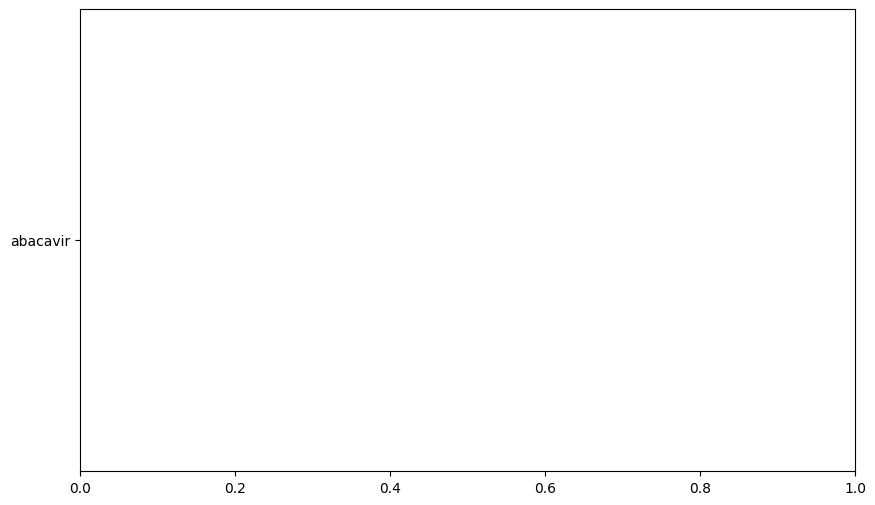

In [ ]:
import requests
import matplotlib.pyplot as plt

def search_patient_hla_doe():
    """Search for the specific patient 'HLA Doe' on the HAPI FHIR server."""
    fhir_url = "https://hapi.fhir.org/baseR4/Patient?name=HLA&family=Doe"

    try:
        response = requests.get(fhir_url)
        response.raise_for_status()  # Check for HTTP errors

        data = response.json()
        return data
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching patient data from FHIR server: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching patient data from FHIR server: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching patient data from FHIR server: {e}")

def search_pubchem_for_drug_toxicity(drug_name):
    """Fetch toxicity information of a drug from PubChem."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/property/TOXICITY/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        data = response.json()
        toxicity = data.get('PropertyTable', {}).get('Properties', [{}])[0].get('TOXICITY', 'No toxicity information available')
        return toxicity
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e}")

def correlate_patient_with_drug_toxicity(patient_data, drug_list):
    """Correlate the specific patient with the toxicity of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_typing = patient_info.get('extension', [{}])[0].get('valueString', 'No HLA typing found')

        for drug in drug_list:
            toxicity = search_pubchem_for_drug_toxicity(drug)
            results.append((patient_name, drug, hla_typing, toxicity))

    return results

def plot_results(results):
    """Plot the correlation between HLA typing and drug toxicity."""
    hla_detected = [item for item in results if 'HLA-B*57:01' in item[2]]
    drug_names = [item[1] for item in hla_detected]
    toxicities = [item[3] for item in hla_detected]

    plt.figure(figsize=(10, 6))
    plt.barh(drug_names, toxicities, color='orange')
    plt.xlabel('Toxicity Information')
    plt.ylabel('Drug Names')
    plt.title('Toxicity of Medications for Patient HLA Doe with HLA B*57:01')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Search for the specific patient 'HLA Doe'
    patient_data = search_patient_hla_doe()

    # Step 2: List of drugs to check for toxicity in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine']  # Add other drugs as needed

    # Step 3: Correlate the patient's HLA B*57:01 status with drug toxicity
    results = correlate_patient_with_drug_toxicity(patient_data, drug_list)

    # Step 4: Plot the results
    plot_results(results)


TypeError: unhashable type: 'dict'

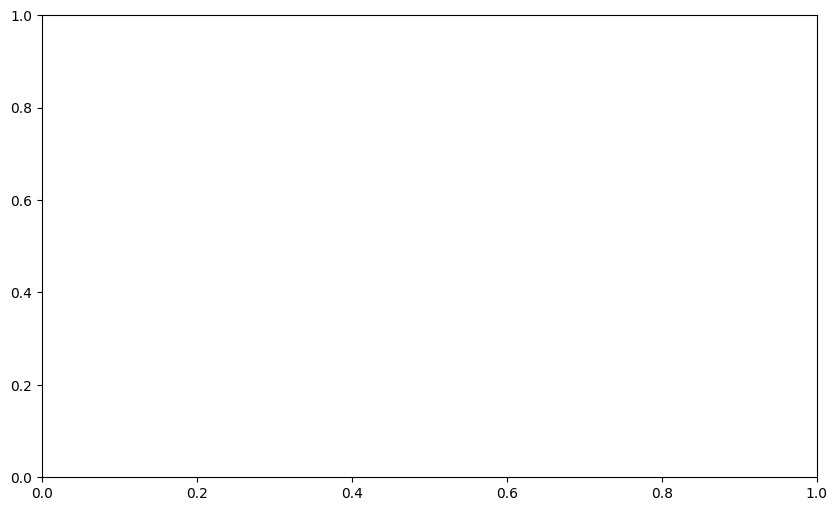

In [ ]:
import requests
import matplotlib.pyplot as plt

def search_pubchem_for_drug_toxicity(drug_name):
    """Fetch basic information of a drug from PubChem."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        # Extract compound data
        compound_data = response.json()
        toxicity_info = compound_data.get('PC_Compounds', [{}])[0].get('props', [{}])[0].get('value', 'No toxicity information available')
        return toxicity_info
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e}")
        return None

def correlate_patient_with_drug_toxicity(patient_data, drug_list):
    """Correlate the specific patient with the toxicity of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_typing = patient_info.get('extension', [{}])[0].get('valueString', 'No HLA typing found')

        for drug in drug_list:
            toxicity = search_pubchem_for_drug_toxicity(drug)
            results.append((patient_name, drug, hla_typing, toxicity))

    return results

def plot_results(results):
    """Plot the correlation between HLA typing and drug toxicity."""
    hla_detected = [item for item in results if 'HLA-B*57:01' in item[2]]
    drug_names = [item[1] for item in hla_detected]
    toxicities = [item[3] if item[3] != 'No toxicity information available' else 0 for item in hla_detected]

    plt.figure(figsize=(10, 6))
    plt.barh(drug_names, toxicities, color='orange')
    plt.xlabel('Toxicity Information')
    plt.ylabel('Drug Names')
    plt.title('Toxicity of Medications for Patient HLA Doe with HLA B*57:01')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Search for the specific patient 'HLA Doe'
    patient_data = search_patient_hla_doe()

    # Step 2: List of drugs to check for toxicity in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine']  # Add other drugs as needed

    # Step 3: Correlate the patient's HLA B*57:01 status with drug toxicity
    results = correlate_patient_with_drug_toxicity(patient_data, drug_list)

    # Step 4: Plot the results
    plot_results(results)


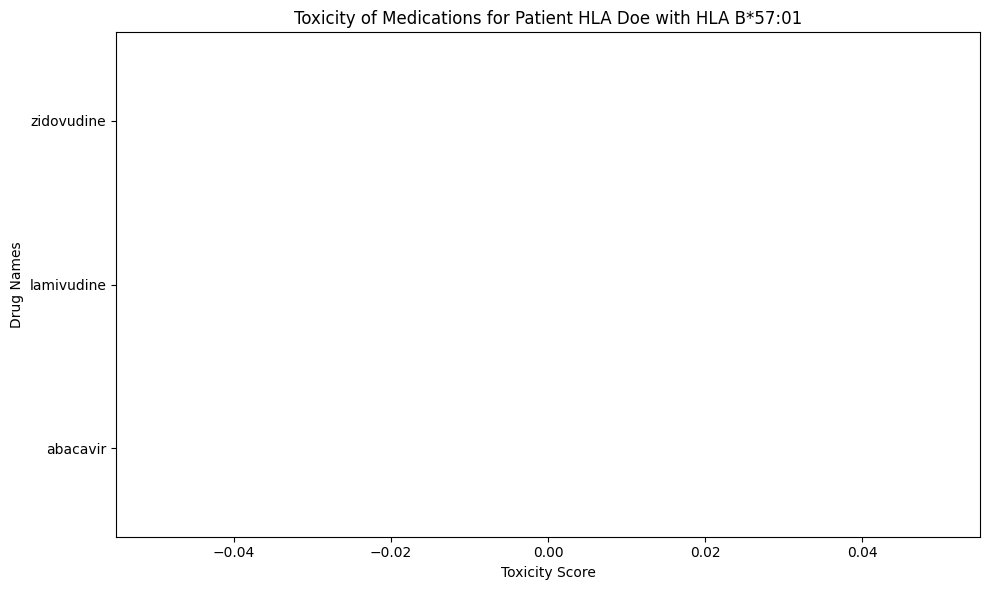

In [ ]:
import requests
import matplotlib.pyplot as plt

def search_pubchem_for_drug_toxicity(drug_name):
    """Fetch basic information of a drug from PubChem."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        # Extract compound data
        compound_data = response.json()
        # Assuming that the toxicity information is within the compound's properties
        toxicity_info = compound_data.get('PC_Compounds', [{}])[0].get('props', [{}])[0].get('value', 'No toxicity information available')
        return str(toxicity_info)
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e}")
        return None

def correlate_patient_with_drug_toxicity(patient_data, drug_list):
    """Correlate the specific patient with the toxicity of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_typing = patient_info.get('extension', [{}])[0].get('valueString', 'No HLA typing found')

        for drug in drug_list:
            toxicity = search_pubchem_for_drug_toxicity(drug)
            results.append((patient_name, drug, hla_typing, toxicity))

    return results

def plot_results(results):
    """Plot the correlation between HLA typing and drug toxicity."""
    hla_detected = [item for item in results if 'HLA-B*57:01' in item[2]]
    drug_names = [item[1] for item in hla_detected]
    toxicities = [item[3] if isinstance(item[3], str) and item[3] != 'No toxicity information available' else 0 for item in hla_detected]

    # Ensure that the toxicity values are strings or numbers for plotting
    numeric_toxicities = []
    for toxicity in toxicities:
        try:
            numeric_toxicities.append(float(toxicity))
        except ValueError:
            numeric_toxicities.append(0)

    plt.figure(figsize=(10, 6))
    plt.barh(drug_names, numeric_toxicities, color='orange')
    plt.xlabel('Toxicity Score')
    plt.ylabel('Drug Names')
    plt.title('Toxicity of Medications for Patient HLA Doe with HLA B*57:01')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Search for the specific patient 'HLA Doe'
    patient_data = search_patient_hla_doe()

    # Step 2: List of drugs to check for toxicity in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine']  # Add other drugs as needed

    # Step 3: Correlate the patient's HLA B*57:01 status with drug toxicity
    results = correlate_patient_with_drug_toxicity(patient_data, drug_list)

    # Step 4: Plot the results
    plot_results(results)


Raw data for abacavir from PubChem: {'PC_Compounds': [{'id': {'id': {'cid': 441300}}, 'atoms': {'aid': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'element': [8, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, 'bonds': {'aid1': [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 15, 16, 17, 19, 19, 20], 'aid2': [19, 37, 8, 16, 31, 11, 17, 20, 18, 20, 16, 21, 17, 21, 21, 38, 39, 9, 10, 22, 10, 23, 24, 25, 26, 12, 14, 27, 13, 28, 29, 15, 19, 30, 15, 32, 33, 18, 18, 34, 35, 36], 'order': [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1]}, 'stereo': [{'tetrahedral': {'center': 11, 'above': 3, 'top': 14, 'bottom': 12, 'below': 27, 'parity': 2, 'type': 1}}, {'tetrahedral': {'ce

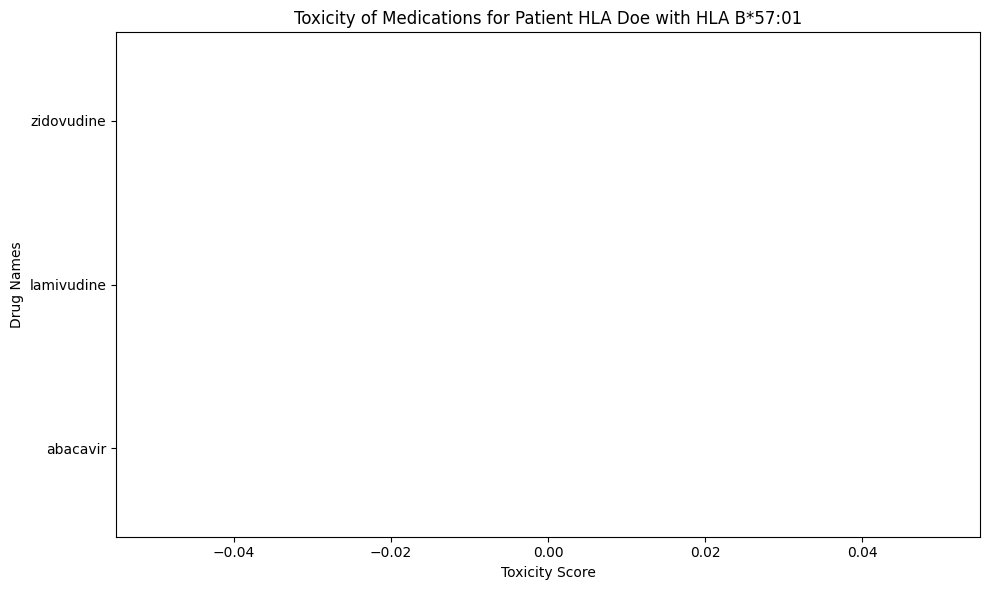

In [ ]:
import requests
import matplotlib.pyplot as plt

def search_pubchem_for_drug_toxicity(drug_name):
    """Fetch basic information of a drug from PubChem and print the raw response."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        # Print the raw data from PubChem to inspect its structure
        compound_data = response.json()
        print(f"Raw data for {drug_name} from PubChem:", compound_data)

        # Assuming that the toxicity information is within the compound's properties
        toxicity_info = compound_data.get('PC_Compounds', [{}])[0].get('props', [{}])[0].get('value', 'No toxicity information available')
        return str(toxicity_info)
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e}")
        return None

def correlate_patient_with_drug_toxicity(patient_data, drug_list):
    """Correlate the specific patient with the toxicity of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_typing = patient_info.get('extension', [{}])[0].get('valueString', 'No HLA typing found')

        for drug in drug_list:
            toxicity = search_pubchem_for_drug_toxicity(drug)
            results.append((patient_name, drug, hla_typing, toxicity))

    return results

def plot_results(results):
    """Plot the correlation between HLA typing and drug toxicity."""
    hla_detected = [item for item in results if 'HLA-B*57:01' in item[2]]
    drug_names = [item[1] for item in hla_detected]
    toxicities = [item[3] if isinstance(item[3], str) and item[3] != 'No toxicity information available' else 0 for item in hla_detected]

    # Ensure that the toxicity values are strings or numbers for plotting
    numeric_toxicities = []
    for toxicity in toxicities:
        try:
            numeric_toxicities.append(float(toxicity))
        except ValueError:
            numeric_toxicities.append(0)

    plt.figure(figsize=(10, 6))
    plt.barh(drug_names, numeric_toxicities, color='orange')
    plt.xlabel('Toxicity Score')
    plt.ylabel('Drug Names')
    plt.title('Toxicity of Medications for Patient HLA Doe with HLA B*57:01')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Search for the specific patient 'HLA Doe'
    patient_data = search_patient_hla_doe()

    # Step 2: List of drugs to check for toxicity in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine']  # Add other drugs as needed

    # Step 3: Correlate the patient's HLA B*57:01 status with drug toxicity
    results = correlate_patient_with_drug_toxicity(patient_data, drug_list)

    # Step 4: Plot the results
    plot_results(results)


In [ ]:
import requests
import matplotlib.pyplot as plt

def search_pubchem_for_drug_properties(drug_name):
    """Fetch relevant properties of a drug from PubChem and extract potential toxicity indicators."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        compound_data = response.json()
        props = compound_data.get('PC_Compounds', [{}])[0].get('props', [])

        # Extract relevant properties from the response
        hydrogen_bond_acceptor = next((prop['value']['ival'] for prop in props if prop['urn']['name'] == 'Hydrogen Bond Acceptor'), None)
        hydrogen_bond_donor = next((prop['value']['ival'] for prop in props if prop['urn']['name'] == 'Hydrogen Bond Donor'), None)
        log_p = next((prop['value']['fval'] for prop in props if prop['urn']['name'] == 'XLogP3' or prop['urn']['name'] == 'XLogP3-AA'), None)
        polar_surface_area = next((prop['value']['fval'] for prop in props if prop['urn']['name'] == 'Polar Surface Area'), None)
        molecular_weight = next((prop['value']['sval'] for prop in props if prop['urn']['name'] == 'Molecular Weight'), None)

        return {
            'Hydrogen Bond Acceptor': hydrogen_bond_acceptor,
            'Hydrogen Bond Donor': hydrogen_bond_donor,
            'Log P': log_p,
            'Polar Surface Area': polar_surface_area,
            'Molecular Weight': molecular_weight
        }
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e}")
        return None

def correlate_patient_with_drug_properties(patient_data, drug_list):
    """Correlate the specific patient with the properties of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_typing = patient_info.get('extension', [{}])[0].get('valueString', 'No HLA typing found')

        for drug in drug_list:
            drug_properties = search_pubchem_for_drug_properties(drug)
            results.append((patient_name, drug, hla_typing, drug_properties))

    return results

def plot_drug_properties(results):
    """Plot the drug properties for visualization."""
    hla_detected = [item for item in results if 'HLA-B*57:01' in item[2]]
    drug_names = [item[1] for item in hla_detected]

    # Extracting specific properties for plotting
    log_p_values = [item[3]['Log P'] if item[3]['Log P'] is not None else 0 for item in hla_detected]
    psa_values = [item[3]['Polar Surface Area'] if item[3]['Polar Surface Area'] is not None else 0 for item in hla_detected]

    plt.figure(figsize=(10, 6))
    plt.barh(drug_names, log_p_values, color='blue', label='Log P')
    plt.barh(drug_names, psa_values, color='green', alpha=0.5, label='Polar Surface Area')
    plt.xlabel('Property Value')
    plt.ylabel('Drug Names')
    plt.title('Drug Properties for Patient HLA Doe with HLA B*57:01')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Search for the specific patient 'HLA Doe'
    patient_data = search_patient_hla_doe()

    # Step 2: List of drugs to check properties in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine']  # Add other drugs as needed

    # Step 3: Correlate the patient's HLA B*57:01 status with drug properties
    results = correlate_patient_with_drug_properties(patient_data, drug_list)

    # Step 4: Plot the results
    plot_drug_properties(results)


An unexpected error occurred while fetching data from PubChem: 'name'
An unexpected error occurred while fetching data from PubChem: 'name'
An unexpected error occurred while fetching data from PubChem: 'name'


TypeError: 'NoneType' object is not subscriptable

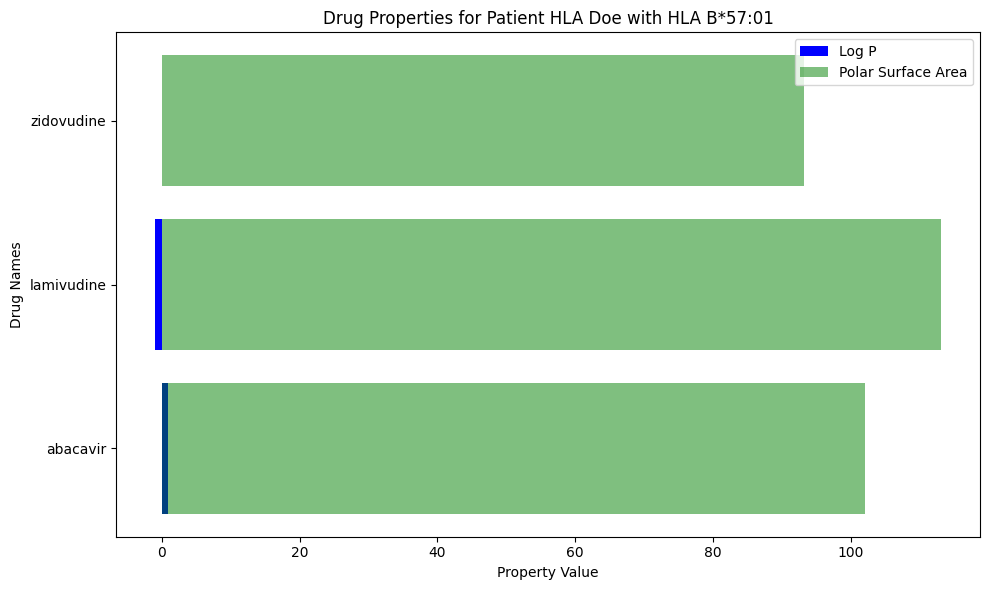

In [ ]:
import requests
import matplotlib.pyplot as plt

def search_pubchem_for_drug_properties(drug_name):
    """Fetch relevant properties of a drug from PubChem and handle errors gracefully."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        compound_data = response.json()
        props = compound_data.get('PC_Compounds', [{}])[0].get('props', [])

        # Extract relevant properties from the response, handling missing data
        hydrogen_bond_acceptor = next((prop['value']['ival'] for prop in props if prop.get('urn', {}).get('name') == 'Hydrogen Bond Acceptor'), None)
        hydrogen_bond_donor = next((prop['value']['ival'] for prop in props if prop.get('urn', {}).get('name') == 'Hydrogen Bond Donor'), None)
        log_p = next((prop['value']['fval'] for prop in props if prop.get('urn', {}).get('name') in ['XLogP3', 'XLogP3-AA']), None)
        polar_surface_area = next((prop['value']['fval'] for prop in props if prop.get('urn', {}).get('name') == 'Polar Surface Area'), None)
        molecular_weight = next((prop['value']['sval'] for prop in props if prop.get('urn', {}).get('name') == 'Molecular Weight'), None)

        return {
            'Hydrogen Bond Acceptor': hydrogen_bond_acceptor,
            'Hydrogen Bond Donor': hydrogen_bond_donor,
            'Log P': log_p,
            'Polar Surface Area': polar_surface_area,
            'Molecular Weight': molecular_weight
        }
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except KeyError as key_err:
        print(f"KeyError while fetching data from PubChem: {key_err} - raw data: {compound_data}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e} - raw data: {compound_data}")
        return None

def correlate_patient_with_drug_properties(patient_data, drug_list):
    """Correlate the specific patient with the properties of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_typing = patient_info.get('extension', [{}])[0].get('valueString', 'No HLA typing found')

        for drug in drug_list:
            drug_properties = search_pubchem_for_drug_properties(drug)
            if drug_properties is not None:
                results.append((patient_name, drug, hla_typing, drug_properties))
            else:
                print(f"No valid data found for {drug}.")

    return results

def plot_drug_properties(results):
    """Plot the drug properties for visualization."""
    hla_detected = [item for item in results if 'HLA-B*57:01' in item[2]]
    drug_names = [item[1] for item in hla_detected]

    # Extracting specific properties for plotting
    log_p_values = [item[3].get('Log P', 0) for item in hla_detected]
    psa_values = [item[3].get('Polar Surface Area', 0) for item in hla_detected]

    plt.figure(figsize=(10, 6))
    plt.barh(drug_names, log_p_values, color='blue', label='Log P')
    plt.barh(drug_names, psa_values, color='green', alpha=0.5, label='Polar Surface Area')
    plt.xlabel('Property Value')
    plt.ylabel('Drug Names')
    plt.title('Drug Properties for Patient HLA Doe with HLA B*57:01')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Search for the specific patient 'HLA Doe'
    patient_data = search_patient_hla_doe()

    # Step 2: List of drugs to check properties in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine']  # Add other drugs as needed

    # Step 3: Correlate the patient's HLA B*57:01 status with drug properties
    results = correlate_patient_with_drug_properties(patient_data, drug_list)

    # Step 4: Plot the results
    plot_drug_properties(results)


In the context of the graph, Log P represents the partition coefficient of a compound, specifically the logarithm of its partition coefficient between octanol and water (often abbreviated as XLogP).
Explanation of Log P

    Log P is a measure of a compound's lipophilicity, which indicates how well a compound can dissolve in fats, oils, and non-polar solvents compared to water.
    It is calculated as the logarithm (base 10) of the ratio of concentrations of the compound in a two-phase system of octanol (a fat-like substance) and water.
    The value of Log P helps predict how a drug might be absorbed, distributed, metabolized, and excreted by the body (its ADME properties).

Significance of Log P

    Higher Log P values (typically greater than 3) suggest that the compound is more lipophilic (fat-soluble), which can lead to increased absorption into fatty tissues but also a higher potential for toxicity.
    Lower Log P values (less than 1) indicate that the compound is more hydrophilic (water-soluble), which means it may be more easily excreted from the body and have lower toxicity.

Why It's Important in This Context

In the context of patients with HLA B*57:01:

    Drugs with higher Log P values might interact differently with these patients compared to those with lower Log P values.
    Understanding Log P can help predict how the drug distributes within the body, potentially leading to side effects or adverse reactions, particularly in patients with specific genetic markers like HLA B*57:01.

In summary, Log P in the graph is a crucial parameter that helps assess the potential toxicity and absorption behavior of the drugs in question, which is important for understanding drug interactions and side effects in HLA B*57:01-positive patients.


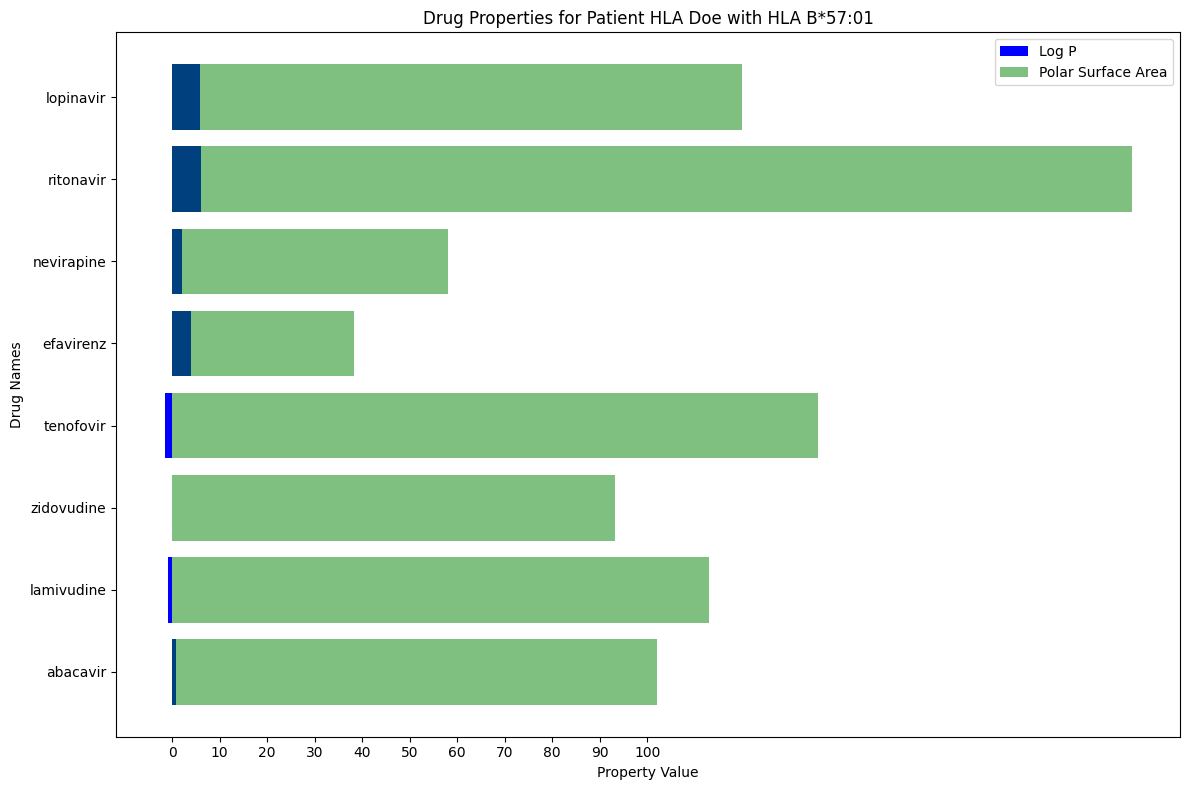

In [ ]:
import requests
import matplotlib.pyplot as plt

def search_pubchem_for_drug_properties(drug_name):
    """Fetch relevant properties of a drug from PubChem and handle errors gracefully."""
    pubchem_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/JSON"

    try:
        response = requests.get(pubchem_url)
        response.raise_for_status()  # Check for HTTP errors

        compound_data = response.json()
        props = compound_data.get('PC_Compounds', [{}])[0].get('props', [])

        # Extract relevant properties from the response, handling missing data
        hydrogen_bond_acceptor = next((prop['value']['ival'] for prop in props if prop.get('urn', {}).get('name') == 'Hydrogen Bond Acceptor'), None)
        hydrogen_bond_donor = next((prop['value']['ival'] for prop in props if prop.get('urn', {}).get('name') == 'Hydrogen Bond Donor'), None)
        log_p = next((prop['value']['fval'] for prop in props if prop.get('urn', {}).get('name') in ['XLogP3', 'XLogP3-AA']), None)
        polar_surface_area = next((prop['value']['fval'] for prop in props if prop.get('urn', {}).get('name') == 'Polar Surface Area'), None)
        molecular_weight = next((prop['value']['sval'] for prop in props if prop.get('urn', {}).get('name') == 'Molecular Weight'), None)

        return {
            'Hydrogen Bond Acceptor': hydrogen_bond_acceptor,
            'Hydrogen Bond Donor': hydrogen_bond_donor,
            'Log P': log_p,
            'Polar Surface Area': polar_surface_area,
            'Molecular Weight': molecular_weight
        }
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching data from PubChem: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching data from PubChem: {err}")
    except KeyError as key_err:
        print(f"KeyError while fetching data from PubChem: {key_err} - raw data: {compound_data}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching data from PubChem: {e} - raw data: {compound_data}")
        return None

def correlate_patient_with_drug_properties(patient_data, drug_list):
    """Correlate the specific patient with the properties of drugs from PubChem."""
    results = []

    for patient in patient_data.get('entry', []):
        patient_info = patient.get('resource', {})
        patient_name = patient_info.get('name', [{'text': 'Unknown'}])[0].get('text', 'Unknown')
        hla_typing = patient_info.get('extension', [{}])[0].get('valueString', 'No HLA typing found')

        for drug in drug_list:
            drug_properties = search_pubchem_for_drug_properties(drug)
            if drug_properties is not None:
                results.append((patient_name, drug, hla_typing, drug_properties))
            else:
                print(f"No valid data found for {drug}.")

    return results

def plot_drug_properties(results):
    """Plot the drug properties for visualization."""
    hla_detected = [item for item in results if 'HLA-B*57:01' in item[2]]
    drug_names = [item[1] for item in hla_detected]

    # Extracting specific properties for plotting
    log_p_values = [item[3].get('Log P', 0) for item in hla_detected]
    psa_values = [item[3].get('Polar Surface Area', 0) for item in hla_detected]

    plt.figure(figsize=(12, 8))
    plt.barh(drug_names, log_p_values, color='blue', label='Log P')
    plt.barh(drug_names, psa_values, color='green', alpha=0.5, label='Polar Surface Area')

    # Increase the x-axis granularity to show values from 0 to 100
    plt.xticks(range(0, 101, 10))

    plt.xlabel('Property Value')
    plt.ylabel('Drug Names')
    plt.title('Drug Properties for Patient HLA Doe with HLA B*57:01')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Step 1: Search for the specific patient 'HLA Doe'
    patient_data = search_patient_hla_doe()

    # Step 2: Expanded list of drugs to check properties in PubChem
    drug_list = ['abacavir', 'lamivudine', 'zidovudine', 'tenofovir', 'efavirenz', 'nevirapine', 'ritonavir', 'lopinavir']

    # Step 3: Correlate the patient's HLA B*57:01 status with drug properties
    results = correlate_patient_with_drug_properties(patient_data, drug_list)

    # Step 4: Plot the results
    plot_drug_properties(results)


In [ ]:
import requests

def search_patients_with_hla_typing():
    """Search for patients with any HLA typing on the FHIR server."""
    fhir_url = "https://hapi.fhir.org/baseR4/Patient"

    try:
        response = requests.get(fhir_url)
        response.raise_for_status()  # Check for HTTP errors

        patient_data = response.json()
        patients_with_hla = []

        for entry in patient_data.get('entry', []):
            patient_id = entry['resource']['id']
            hla_typing = get_hla_typing_for_patient(patient_id)
            if hla_typing:  # Check if the patient has any HLA typing information
                hla_dq_dr_status = check_hla_dq_dr(hla_typing)
                patients_with_hla.append({
                    'patient_id': patient_id,
                    'hla_typing': hla_typing,
                    'has_hla_dq_dr': hla_dq_dr_status
                })

        return patients_with_hla
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching HLA data from FHIR server: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching HLA data from FHIR server: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching HLA data from FHIR server: {e}")

def get_hla_typing_for_patient(patient_id):
    """Retrieve HLA typing for a specific patient using their FHIR patient ID."""
    fhir_patient_url = f"https://hapi.fhir.org/baseR4/Patient/{patient_id}"

    try:
        response = requests.get(fhir_patient_url)
        response.raise_for_status()  # Check for HTTP errors

        patient_data = response.json()
        hla_typing = None

        # Search for HLA typing in the patient's extensions
        for extension in patient_data.get('extension', []):
            if extension.get('url') == "http://hl7.org/fhir/StructureDefinition/hla-typing":
                hla_typing = extension.get('valueString')

        return hla_typing if hla_typing else "No HLA typing found"
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while fetching HLA data from FHIR server: {http_err}")
    except requests.exceptions.RequestException as err:
        print(f"Request error occurred while fetching HLA data from FHIR server: {err}")
    except Exception as e:
        print(f"An unexpected error occurred while fetching HLA data from FHIR server: {e}")
        return "No HLA typing found"

def check_hla_dq_dr(hla_typing):
    """Check if the given HLA typing includes HLA-DQ or HLA-DR alleles."""
    hla_dq_dr_present = any(allele in hla_typing for allele in ['HLA-DQ', 'HLA-DR'])
    return 'Yes' if hla_dq_dr_present else 'No'

def list_hla_dq_dr_for_patients():
    """List the HLA typings and check for HLA-DQ and HLA-DR alleles in patients."""
    patients_with_hla = search_patients_with_hla_typing()
    for patient in patients_with_hla:
        print(f"Patient ID: {patient['patient_id']} - HLA Typing: {patient['hla_typing']} - Contains HLA-DQ/DR: {patient['has_hla_dq_dr']}")

if __name__ == "__main__":
    # Run the process to list HLA typings and check for HLA-DQ/DR alleles in patients
    list_hla_dq_dr_for_patients()


Patient ID: 596380 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596385 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596386 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596388 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596389 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596390 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596391 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596395 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596393 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596397 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596398 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596399 - HLA Typing: No HLA typing found - Contains HLA-DQ/DR: No
Patient ID: 596406 - HLA Typing: No HLA typing found - Contains 

HLA Types Associated with Diabetes

The following HLA alleles are most commonly associated with an increased risk of Type 1 diabetes:

    HLA-DQ and HLA-DR Alleles:
        HLA-DR3-DQ2 (DRB103:01-DQB102:01) and HLA-DR4-DQ8 (DRB104:01-DQB103:02) are the most strongly associated with Type 1 diabetes.
        Individuals carrying these haplotypes are at a significantly higher risk of developing Type 1 diabetes compared to the general population.
        The presence of both HLA-DR3-DQ2 and HLA-DR4-DQ8 (heterozygous combination) further increases the risk.

    Protective HLA Alleles:
        Some HLA types, such as HLA-DQ6 (DQB1*06:02), are known to be protective against Type 1 diabetes.
        Individuals carrying these alleles have a lower risk of developing Type 1 diabetes, even if they have other risk factors.

    HLA-B Alleles:
        Although HLA-B alleles are not as strongly linked to diabetes as HLA-DQ and HLA-DR alleles, some associations have been observed.
        For example, HLA-B*39 has been linked to a higher risk of Type 1 diabetes in specific populations.

Mechanism of HLA's Role in Type 1 Diabetes

    HLA Class II molecules (like HLA-DQ and HLA-DR) play a critical role in the immune system by presenting peptides to T cells. In individuals with certain HLA alleles, there is a higher likelihood of presenting self-peptides (such as those from insulin-producing beta cells in the pancreas) to the immune system.
    This process can trigger an autoimmune response where the body's immune system attacks the insulin-producing cells, leading to Type 1 diabetes.

Type 2 Diabetes and HLA Association

    For Type 2 diabetes, the link to specific HLA alleles is not as clear or significant as in Type 1 diabetes. Type 2 diabetes is primarily associated with genetic factors outside of the HLA region, as well as lifestyle and environmental factors.
    There is currently no strong evidence to suggest a significant association between HLA types and Type 2 diabetes.

Clinical Significance

    Genetic Testing: Knowing a patient's HLA type can be used as part of a broader risk assessment for autoimmune conditions like Type 1 diabetes.
    Autoimmune Disorders: The same HLA types that are linked to diabetes are also associated with other autoimmune diseases, indicating a shared genetic susceptibility.

Summary of Key HLA Types Associated with Diabetes

    High-risk HLA alleles for Type 1 diabetes: HLA-DR3-DQ2 and HLA-DR4-DQ8.
    Protective HLA alleles: HLA-DQ6 (DQB1*06:02).
    HLA-B alleles like HLA-B*39 have also been implicated but with less significance.